In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, KFold
from sklearn.feature_selection import f_regression, mutual_info_regression, f_classif
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import r2_score
import seaborn as sns
from scipy.stats import pearsonr

pd.set_option('display.max_columns', None)

In [24]:
#read in training file 
training_data = pd.read_csv('../Data/hip_fracture_training.csv')


In [7]:
def filter_data(df, preop_cols): 

    #filters for only the preoperative columns
    df_preop = df[preop_cols]

    return df_preop    

In [8]:
preop_cols = ['PRSODM', 'PRBUN', 'PRCREAT', 'PRWBC', 'PRHCT', 'PRPLATE', 
              'SmokePre_37', 'DyspneaPre_38', 'DyspneaPre_39', 'DyspneaPre_40', 
              'FncStatusPre_41', 'FncStatusPre_42', 'FncStatusPre_43', 'FncStatusPre_44', 
              'VentDepPre_46', 'COPDPre_48', 'AscitesPre_50', 'CHFPre_52', 'HTNPre_54', 
              'DialysisPre_56', 'CancerPre_58', 'WoundInfectionPre_60', 'SteroidPre_62', 
              'WtLossPre_64', 'BleedingDisPre_66', 'TfnPre_68', 'SepsisPre_69', 'SepsisPre_70', 
              'SepsisPre_71', 'SepsisPre_72', 'ASAPre_73', 'ASAPre_74', 'ASAPre_75', 'ASAPre_76', 
              'ASAPre_77', 'ASAPre_78', 'PreOpDementia_2', 'PreOpDelirium_5', 'PreOpBoneMeds_7', 
              'PreOpMOBAID_10', 'PreOpPressSore_12', 'PartialorFullFuncStatus', 'DiabetesBinary',
              'MFI5','READMISSION30D']
preop_df = filter_data(training_data, preop_cols)

In [17]:
#next we need to scale the lab values 
lab_cols = ['PRSODM', 'PRBUN', 'PRCREAT', 'PRWBC', 'PRHCT', 'PRPLATE']

def scale_labs(df, lab_cols):
    # create a DataFrame with only the lab columns
    lab_df = df[lab_cols]

    # replace missing values (-99) with NaN
    lab_df = lab_df.replace(-99, np.nan)

    # impute missing values with the median
    imputer = SimpleImputer(strategy='median')
    
    #transform lab values 
    lab_df = imputer.fit_transform(lab_df)

    # create a StandardScaler object
    scaler = StandardScaler()

    # fit the scaler to the lab data
    scaler.fit(lab_df)

    # transform the lab data
    scaled_data = scaler.transform(lab_df)

    # create a new DataFrame with the scaled lab data
    scaled_lab_df = pd.DataFrame(scaled_data, columns=lab_cols)

    # create a new DataFrame that contains both the scaled lab columns and the other columns from the input DataFrame
    new_df = pd.concat([df.drop(lab_cols, axis=1), scaled_lab_df], axis=1)

    return new_df


scaled_df  = scale_labs(preop_df, lab_cols)



In [19]:
def split_data(df): 
    X = df.drop(labels = ['READMISSION30D'], axis = 1) 
    y = pd.DataFrame(df['READMISSION30D']) 
    X_train,X_test,y_train,y_test = train_test_split(X, y, stratify = y, test_size= .2, random_state= 0 )
    return X_train,X_test,y_train,y_test

X_train,X_test,y_train,y_test = split_data(scaled_df)
display(X_train.info()) 
display(X_test.info())
display(y_train.info())
display(y_test.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 23350 entries, 12914 to 4404
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SmokePre_37              23350 non-null  int64  
 1   DyspneaPre_38            23350 non-null  int64  
 2   DyspneaPre_39            23350 non-null  int64  
 3   DyspneaPre_40            23350 non-null  int64  
 4   FncStatusPre_41          23350 non-null  int64  
 5   FncStatusPre_42          23350 non-null  int64  
 6   FncStatusPre_43          23350 non-null  int64  
 7   FncStatusPre_44          23350 non-null  int64  
 8   VentDepPre_46            23350 non-null  int64  
 9   COPDPre_48               23350 non-null  int64  
 10  AscitesPre_50            23350 non-null  int64  
 11  CHFPre_52                23350 non-null  int64  
 12  HTNPre_54                23350 non-null  int64  
 13  DialysisPre_56           23350 non-null  int64  
 14  CancerPre_58       

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5838 entries, 28216 to 13720
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SmokePre_37              5838 non-null   int64  
 1   DyspneaPre_38            5838 non-null   int64  
 2   DyspneaPre_39            5838 non-null   int64  
 3   DyspneaPre_40            5838 non-null   int64  
 4   FncStatusPre_41          5838 non-null   int64  
 5   FncStatusPre_42          5838 non-null   int64  
 6   FncStatusPre_43          5838 non-null   int64  
 7   FncStatusPre_44          5838 non-null   int64  
 8   VentDepPre_46            5838 non-null   int64  
 9   COPDPre_48               5838 non-null   int64  
 10  AscitesPre_50            5838 non-null   int64  
 11  CHFPre_52                5838 non-null   int64  
 12  HTNPre_54                5838 non-null   int64  
 13  DialysisPre_56           5838 non-null   int64  
 14  CancerPre_58       

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23350 entries, 12914 to 4404
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   READMISSION30D  23350 non-null  int64
dtypes: int64(1)
memory usage: 364.8 KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5838 entries, 28216 to 13720
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   READMISSION30D  5838 non-null   int64
dtypes: int64(1)
memory usage: 91.2 KB


None

In [27]:
def rf_feature_importance(X_train,X_test,y_train): 

    #we will start off using the default scikit learn features 
    rf_model = RandomForestClassifier(criterion='gini',max_depth=None, min_samples_leaf=5,n_estimators=1000,
                                 max_features=0.1,max_samples=0.7,random_state=0)
     #Fit the tree to the data
    rf_model.fit(X_train, y_train)

    #predict on the validation set
    preds = rf_model.predict(X_test)

    #define feature names 
    feat_names = X_train.columns 

    #define the number of features to show
    num_to_show = 55 

    # Determine the relative importance of each feature using the random forest model
    importances = rf_model.feature_importances_

    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:30][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()

    return RF_ranking, rf_model, preds

/var/folders/jc/0mjbccp53cqfmdh6hlys5sx40000gn/T/ipykernel_31068/2598169905.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


,Feat Index,Feature,Importance
0,40,PRCREAT,0.128023
1,42,PRHCT,0.127841
2,41,PRWBC,0.123434
3,43,PRPLATE,0.123201
4,39,PRBUN,0.109458
5,38,PRSODM,0.084643
6,37,MFI5,0.030337
7,32,PreOpBoneMeds_7,0.018263
8,33,PreOpMOBAID_10,0.018057
9,30,PreOpDementia_2,0.016199


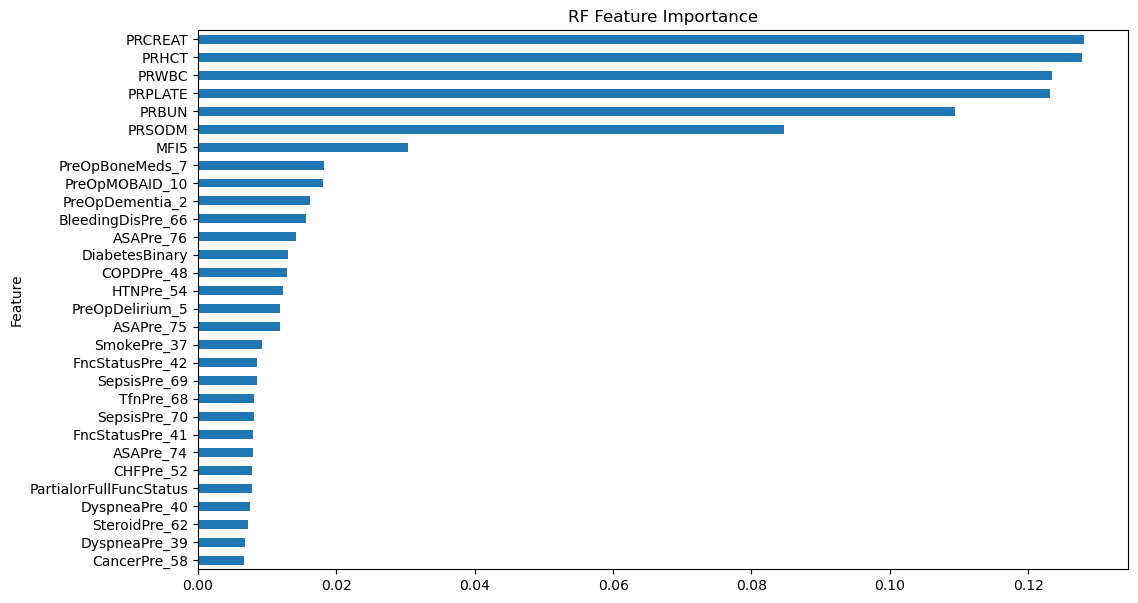

In [28]:
RF_ranking, rf_model, preds = rf_feature_importance(X_train,X_test,y_train)


/Users/brunovalan/opt/anaconda3/envs/AIPI510/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunovalan/opt/anaconda3/envs/AIPI510/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/brunovalan/opt/anaconda3/envs/AIPI510/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

the results for RandomForestClassifier(max_features=0.1, max_samples=0.7, min_samples_leaf=5,
                       n_estimators=1000, random_state=0)              precision    recall  f1-score   support

           0       0.90      1.00      0.95      5277
           1       0.00      0.00      0.00       561

    accuracy                           0.90      5838
   macro avg       0.45      0.50      0.47      5838
weighted avg       0.82      0.90      0.86      5838



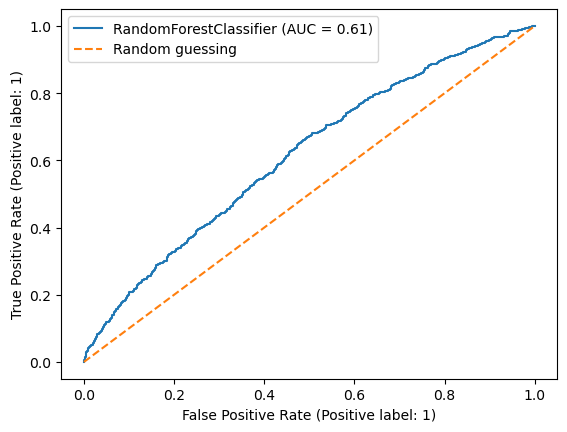

In [29]:
print(f'the results for {rf_model}' + classification_report(y_test, preds))
plot_roc_curve(rf_model,X_test,y_test)
# Add a line to show the curve for random guessing
plt.plot([0,1],[0,1],linestyle='--',label='Random guessing')
plt.legend()
plt.show()

In [30]:
#lets try univariate testing on our numerical and catagorical columns 
def cat_feature_selection(cat_data,y):
    '''
    Performs a univariate feature selection test on the categorical features and returns the test scores for each feature

    Inputs:
        cat_data(pd.DataFrame): dataframe containing the categorical features only from the training set
        y(pd.DataFrame): training set labels

    Returns:
        anova_scores(pd.DataFrame): dataframe containing the feature names and score for each   
    '''
    ### BEGIN SOLUTION ###

    # Categorical features - need to convert to numerical codes prior to statistical tests
    X_featselect_cat = cat_data
    X_featselect_cat = X_featselect_cat.astype('category')
    X_featselect_cat = X_featselect_cat.apply(lambda x: x.cat.codes,axis=0)
    

    # Run ANOVA test
    anova_test = SelectKBest(score_func=f_classif, k='all')
    anova_fit = anova_test.fit(X_featselect_cat,y)

    # Put scores and features names in a dataframe
    anova_scores = pd.DataFrame(anova_fit.scores_)
    dfcolumns = pd.DataFrame(X_featselect_cat.columns)
    anova_scores = pd.concat([dfcolumns,anova_scores],axis=1)
    anova_scores.columns = ['Feature','Score']  

    # Sort them by value
    anova_scores = anova_scores.sort_values(by='Score',ascending=False)
    return anova_scores

#perform univariate feature selection 
def cont_feat_selection(cont_data,y):
    '''
    Performs a univariate feature selection test on the continuous features and returns the test scores for each feature

    Inputs:
        cont_data(pd.DataFrame): dataframe containing only the continuous features from the training set
        y(pd.DataFrame): training set labels

    Returns:
        f_scores(pd.DataFrame): dataframe containing the feature names and score for each feature
    '''
    ### BEGIN SOLUTION ###
    ftest = SelectKBest(score_func=f_regression, k='all')
    fit_ftest = ftest.fit(cont_data,y)
    f_scores = pd.DataFrame(fit_ftest.scores_)
    dfcolumns = pd.DataFrame(cont_data.columns)
    f_scores = pd.concat([dfcolumns,f_scores],axis=1)
    f_scores.columns = ['Feature','Score']  
    f_scores = f_scores.sort_values(by='Score',ascending=False)
    return f_scores


In [ ]:
cont_vars = ['PRSODM', 'PRBUN', 'PRCREAT', 'PRWBC', 'PRHCT', 'PRPLATE']
cat_vars = ['SmokePre_37', 'DyspneaPre_38', 'DyspneaPre_39', 'DyspneaPre_40', 
              'FncStatusPre_41', 'FncStatusPre_42', 'FncStatusPre_43', 'FncStatusPre_44', 
              'VentDepPre_46', 'COPDPre_48', 'AscitesPre_50', 'CHFPre_52', 'HTNPre_54', 
              'DialysisPre_56', 'CancerPre_58', 'WoundInfectionPre_60', 'SteroidPre_62', 
              'WtLossPre_64', 'BleedingDisPre_66', 'TfnPre_68', 'SepsisPre_69', 'SepsisPre_70', 
              'SepsisPre_71', 'SepsisPre_72', 'ASAPre_73', 'ASAPre_74', 'ASAPre_75', 'ASAPre_76', 
              'ASAPre_77', 'ASAPre_78', 'PreOpDementia_2', 'PreOpDelirium_5', 'PreOpBoneMeds_7', 
              'PreOpMOBAID_10', 'PreOpPressSore_12', 'PartialorFullFuncStatus', 'DiabetesBinary',
              'MFI5']